In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from bs4 import BeautifulSoup
import time
import random
import re
import json
import os
from tqdm import tqdm

# Scrapping Data

Article URLs

In [ ]:
#Configuration
base_url = "https://tr.khanacademy.org"
start_url = "https://tr.khanacademy.org/science/biology"
output_filename = "data/khanacademy_bio_articles_urls.json"

options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument("--window-size=1920,1080")
options.add_argument("--log-level=3") 

driver = webdriver.Chrome(options=options)

data = {}

article_pattern = re.compile(r"/a/")

try:
    for class_num in range(1, 2):    
        print(f"Accessing Main Page: {start_url}")
        driver.get(start_url)
        
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
        time.sleep(random.randint(2, 4))

        soup = BeautifulSoup(driver.page_source, 'html.parser')

        #Find all Unit URLs
        unit_links = []
        raw_links = soup.find_all('a', href=True)
        
        for a in raw_links:
            href = a['href']
            if "/science/biology/" in href and href != "/science/biology" and "javascript" not in href:
                full_unit_url = base_url + href if href.startswith("/") else href
                if full_unit_url not in unit_links:
                    unit_links.append(full_unit_url)

        # Initialize list for this class
        class_data = []

        # Process each Unit
        for unit_number, unit_url in enumerate(tqdm(unit_links, desc=f"Scraping Class {class_num}"), start=1):
            driver.get(unit_url)
            time.sleep(random.randint(1, 3)) # Sleep to be polite and let JS load
            
            unit_soup = BeautifulSoup(driver.page_source, 'html.parser')
            
            # Find Article URLs in this Unit
            found_urls = []
            
            # Find all links on the page
            all_anchors = unit_soup.find_all("a", href=True)
            
            for anchor in all_anchors:
                href = anchor['href']
                # Check if it is an article link (/a/) and not a video link (/v/)
                if "/a/" in href:
                    full_url = base_url + href if href.startswith("/") else href
                    
                    # Avoid duplicates and ensure it's a valid link
                    if full_url not in found_urls:
                        found_urls.append(full_url)
            
            if not found_urls:
                class_data.append({
                    "unit_number": unit_number,
                    "non_video_urls": None
                })
            else:
                class_data.append({
                    "unit_number": unit_number,
                    "non_video_urls": found_urls
                })

        data[f"class_{class_num}"] = class_data

finally:
    driver.quit()

# Save to JSON
with open(f"./data/{output_filename}", 'w', encoding='utf-8') as json_file:
    json.dump(data, json_file, ensure_ascii=False, indent=4)

print(f"Data has been successfully saved to {output_filename}")

Video URLs

In [ ]:
# Configuration
base_url = "https://tr.khanacademy.org"
start_url = "https://tr.khanacademy.org/science/biology"
output_filename = "data/khanacademy_bio_vids_urls.json"

options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument("--window-size=1920,1080")
options.add_argument("--log-level=3") 

driver = webdriver.Chrome(options=options)

data = {}

try:
    for class_num in range(1, 2):    
        print(f"Accessing Main Page: {start_url}")
        driver.get(start_url)

        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
        time.sleep(random.randint(2, 4))

        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Find all Unit URLs
        unit_links = []
        raw_links = soup.find_all('a', href=True)
        
        for a in raw_links:
            href = a['href']
            if "/science/biology/" in href and href != "/science/biology" and "javascript" not in href:
                full_unit_url = base_url + href if href.startswith("/") else href
                if full_unit_url not in unit_links:
                    unit_links.append(full_unit_url)

        # Initialize list for this class
        class_data = []

        print(f"Found {len(unit_links)} units.")

        # Process each Unit
        for unit_number, unit_url in enumerate(tqdm(unit_links, desc=f"Scraping Class {class_num}"), start=1):
            driver.get(unit_url)
            
            try:
                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
            except:
                print(f"Timeout loading {unit_url}")
                
            time.sleep(random.randint(1, 3)) 

            unit_soup = BeautifulSoup(driver.page_source, 'html.parser')
            
            # Find Video URLs in this Unit
            unit_video_links = []
            
            all_anchors = unit_soup.find_all("a", href=True)
            
            for anchor in all_anchors:
                href = anchor['href']
                
                # Check for video link pattern /v/
                if "/v/" in href:
                    full_url = base_url + href if href.startswith("/") else href
                    
                    # Avoid duplicates
                    if full_url not in unit_video_links:
                        unit_video_links.append(full_url)
            
            if not unit_video_links:
                class_data.append({
                    "unit_number": unit_number,
                    "video_number": 0,
                    "video_urls": None
                })
            else:
                class_data.append({
                    "unit_number": unit_number,
                    "video_number": len(unit_video_links),
                    "video_urls": unit_video_links
                })

        data[f"class_{class_num}"] = class_data

finally:
    driver.quit()

# Save the data to a JSON file
with open(output_filename, 'w', encoding='utf-8') as json_file:
    json.dump(data, json_file, ensure_ascii=False, indent=4)

print(f"Data has been successfully saved to {output_filename}")

Article Data

In [ ]:
def clean_text(text):
    text = text.replace('\xa0', ' ')
    text = re.sub(r'[^\S\r\n]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.replace("Created with Raphaël", "").strip()
    return text

def remove_duplicates_preserve_order(input_list):
    seen = set()
    result = []
    for item in input_list:
        cont = False
        for result_item in result:
            if item in result_item:
                cont = True
                break
        if cont:
            continue
        if item not in seen:
            result.append(item)
            seen.add(item)
    return result

def add_space_after_punctuation(text):
    pattern = r'([.,!?;:])(?=\S)'
    corrected_text = re.sub(pattern, r'\1 ', text)
    return corrected_text

def split_camel_case(text):
    split_text = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', text)
    return split_text

def read_json(file_path):
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920,1080")
    
    driver = webdriver.Chrome(options=options)
    
    results = []

    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Initialize tqdm progress bar with a fixed total of 126 URLs
    with tqdm(total=126, desc="Processing URLs") as pbar:
        for class_name, units in data.items():
            for unit in units:
                unit_number = unit["unit_number"]
                non_video_urls = unit.get("non_video_urls")

                if non_video_urls:
                    for url in non_video_urls:
                        try:
                            driver.get(url)
                            WebDriverWait(driver, 10).until(
                                EC.presence_of_element_located((By.CLASS_NAME, '_1ge0o9y3'))
                            )
                            soup = BeautifulSoup(driver.page_source, 'html.parser')

                            titles = soup.find_all('h1', class_='_1ge0o9y3')
                            print("title", titles)
                            title_text = ""
                            for title in titles:
                                title_text = title.get_text(strip=True)

                            # Wait until the parent element with class '_1h1mqh3' is present
                            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, '_1h1mqh3')))

                            parent_element = soup.find('div', class_='_1h1mqh3')

                            content_list = []

                            if parent_element:
                                sub_elements = parent_element.find_all(class_='paragraph')
                                
                                for sub_element in sub_elements:
                                    text = clean_text(sub_element.get_text())
                                    if text and text not in content_list:
                                        content_list.append(text)

                            content_list = remove_duplicates_preserve_order(content_list)
                            full_contents = "\n".join(content_list)
                            full_contents = add_space_after_punctuation(full_contents)
                            full_contents = split_camel_case(full_contents)

                            results.append({
                                "url": url,
                                "title": title_text,
                                "contents": full_contents
                            })

                        except Exception as e:
                            print(f"Error processing {url}: {e}")
                            # Continue to the next URL if an error occurs
                            continue

                        # Update progress bar
                        pbar.update(1)

    driver.quit()

    fname = "data/biology_extracted_articles.json"

    # Write results to a new JSON file
    with open(fname, 'w', encoding='utf-8') as outfile:
        json.dump(results, outfile, indent=4, ensure_ascii=False)
    
    print(f"Contents successfully saved to {fname}")

file_path = 'data/khanacademy_bio_articles_urls.json'
read_json(file_path)

Video Transcripts

In [ ]:
def get_total_link_number(file_path):

    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    total = 0
    # Initialize tqdm progress bar with a fixed total of 126 URLs
    for _ , units in data.items():

        for unit in units:
            
            video_number = unit.get("video_number")

            total += video_number
            
    return total

def read_json(file_path):
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920,1080")
    
    driver = webdriver.Chrome(options=options)

    results = []

    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)


    # Initialize tqdm progress bar with a fixed total of 126 URLs
    with tqdm(total=get_total_link_number(file_path), desc="Processing URLs") as pbar:
        for class_num , units in data.items():

            class_unit_data = []
            for unit in units:
                
                video_urls = unit.get("video_urls")
                unit_number = unit.get("unit_number")

                if video_urls:
                    for url in video_urls:
                        try:
                            driver.get(url)
                            time.sleep(random.randint(2, 3))

                            soup = BeautifulSoup(driver.page_source, 'html.parser')

                            # Wait until the titles with class '_qts7xbw' are present
                            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, '_1ge0o9y3')))

                            titles = soup.find_all('h1', class_='_1ge0o9y3')
                            title_text = ""
                            for title in titles:
                                title_text = title.get_text(strip=True)

                            transcript_text_content = None
                            try:
                                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, '_1fezbb8')))
                                transcript_parent = soup.find(class_="_1fezbb8")
                                transcript_text_content = transcript_parent.get_text()
                            except TimeoutException:
                                print("Element with class '_1fezbb8' not found within the given time.")

                            class_unit_data.append({
                                "url": url,
                                "title": title_text,
                                "contents": transcript_text_content
                            })

                        except Exception as e:
                            print(f"Error processing {url}: {e}")
                            # Continue to the next URL if an error occurs
                            continue

                        # Update progress bar
                        pbar.update(1)

            results.extend(class_unit_data)
            
    driver.quit()

    fname = "data/biology_video_transcripts.json"

    # Write results to a new JSON file
    with open(fname, 'w', encoding='utf-8') as outfile:
        json.dump(results, outfile, indent=4, ensure_ascii=False)
    
    print(f"Contents successfully saved to {fname}")

file_path = 'data/khanacademy_bio_vids_urls.json'
read_json(file_path)

Clean null contents

In [ ]:
files = ["data/biology_extracted_articles.json", "data/biology_video_transcripts.json"]

for file_path in files:
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    original_count = len(data)
    cleaned_data = []

    for item in data:
        content = item.get('contents')
        
        if content:
            cleaned_data.append(item)

    removed_count = original_count - len(cleaned_data)
    
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(cleaned_data, f, ensure_ascii=False, indent=4)

    print(f"{removed_count} empty contents removed.")
    print(f"New count: {len(cleaned_data)}\n")

# Other corrupted contents are removed manually.

# Generating Questions and Answers

Generate Questions

In [ ]:
from api import *

In [13]:
def create_video_prompt(text, title):
    prompt = f"""
    Biyoloji dersinde, verilen metnin başlığı '{title}'. Bu metin aslında bir video transkripti; 
    bu yüzden metni dikkatlice okuyup, konuya dair anlamlı, hatasız ve tekrarsız 4 soru üretmeniz bekleniyor.
    
    - Sorular yalnızca metinde açıkça belirtilen bilgilere dayanmalıdır.
    - Videoda gösterilen ancak metinde açıkça belirtilmeyen görsel veya figürlere dayalı sorulardan kaçının.
    - Eğer transkript sadece belirli bir örneği açıklıyorsa, o örneğe bağlı kalmadan genel bilgiler üzerine sorular üretin.
    - Soruların genel ve kavramsal bilgilere dayalı olması gerekmektedir; özel veya aşırı detaylı bilgilere dayanan sorulardan kaçınmalısınız.

    Örneğin, metinde: "Cebirsel ifadelerde ilk olarak eksi yedi ile sekiz çarpı x'in toplamı isteniyor. 
    Toplam dediği için burada toplama işlemi yapacağız."
    İyi soru örneği: "Cebirsel ifadelerde toplama işlemi nasıl yapılır?"
    Kötü soru örneği: "Cebirsel ifadelerde toplama işleminin nasıl yapıldığını anlatırken hangi örneği kullanılmıştır?" 
    Bu tür spesifik sorulardan kaçınmalısınız

    Metin: {text}
    
    - Sorularınızı aşağıdaki formatta oluşturun:
      İlk soru || İkinci soru || Üçüncü soru || Dördüncü soru
    
    Soruların kesinlikle belirtilen formatta olması gerekmektedir ve sorular dışında başka hiçbir şey yazılmamalıdır.
    """
    return prompt


In [ ]:
def create_article_prompt(text, title):
    prompt = f"""
    Biyoloji dersinde, verilen metnin başlığı '{title}'.
    Bu metni anlayıp, konuya dair anlamlı, doğru ve hatasız 10 soru üretmen bekleniyor.
    Metin: {text}
    
    - Soruları aşağıdaki formatta oluştur:
    üreteceğin ilk soru || üreteceğin ikinci soru || ...
    
    -Soruların kesinlikle belirtilen formatta olması gerekmektedir. soru hariç başka hiçbir şey yazmaman gerekmektedir,
    """
    return prompt


In [6]:
def get_questions(text):
    pattern = r'\s*([^|]+?)\s*(?=\s*\|\|)'

    questions = re.findall(pattern, text)
    questions = [q.strip() for q in questions if q.strip()]
    
    return questions

In [ ]:
def get_quest_dict(data, prompt_function):
    answers = {}
    not_formatted = []
    client = connect_azure_gpt()
    for example in data:
        # Skip if content is empty
        if example['contents'] == "":
            continue
        my_prompt = prompt_function(example['contents'] ,example['title'])
        answer = generate_answer(client, my_prompt , "")
        questions = get_questions(answer)
        if questions:
            answers[example['title']]= questions
        else:
            not_formatted.append(answer)
    return answers, not_formatted


In [ ]:
file_name = "data/biology_video_transcripts.json"
with open(file_name, encoding='utf-8') as file:
    data = json.load(file)

video_questions, _ = get_quest_dict(data, create_video_prompt)

file_name = "data/biology_extracted_articles.json"
with open(file_name, encoding='utf-8') as file:
    data = json.load(file)

article_questions, _ = get_quest_dict(data, create_article_prompt)

all_questions = video_questions + article_questions

output_file = 'biology_questions.json'
with open(output_file, 'w', encoding='utf-8') as file:
    json.dump(all_questions, file, ensure_ascii=False, indent=4)

Generate Answers

In [ ]:
def create_cot_prompt(question, text, title):
    cot_prompt = f"""
    Biyoloji dersinde, verilen metnin başlığı '{title}'. 
    Bu metni dikkatlice okuyun ve soruyu cevaplamadan önce gerekli bağlamı veya arka plan bilgisini analiz edin. 
    Mantıklı sonuçlara ulaşmak için düşünce zincirini kullanarak adım adım ilerleyin ve sorunun nihai cevabını verin. Hiçbir soruyu asla atlamayın.

    Metin: {text}
    Soru: {question}
   
    Sorunun çözüm sürecini adım adım metne dayanmalı ve en önemli noktaları içermelidir. 
    Gereksiz bilgi veya gereksiz uzatma olmadan adım adım düşünerek Düşünce Zinciri (Chain of Thought) ile çözün.
    Her soru için 3 cevap oluşturun. İlk iki cevap kısa ve öz olmalı, üçüncü cevap ise daha ayrıntılı ve kapsamlı olmalıdır.
    
    Cevabın formatı şu şekilde olmalıdır:
    Üreteceğin ilk kısa ve öz cevap || Üreteceğin ikinci kısa ve öz cevap || Üreteceğin ayrıntılı ve kapsamlı cevap
    """
    return cot_prompt

In [ ]:
def parse_three_answers(response_text):
    if not response_text:
        return None, None, None
        
    parts = response_text.split('||')
    cleaned_parts = [p.strip() for p in parts if p.strip()]
    
    # Eğer 3 parçadan az veya çok geldiyse kontrol et
    if len(cleaned_parts) >= 3:
        return cleaned_parts[0], cleaned_parts[1], cleaned_parts[2]
    elif len(cleaned_parts) == 2:
        return cleaned_parts[0], cleaned_parts[1], ""
    elif len(cleaned_parts) == 1:
        return cleaned_parts[0], "", ""
    else:
        return "", "", ""

In [ ]:
client = connect_azure_gpt()

# Load source texts
content_map = {}

source_files = [
    "data/biology_video_transcripts.json", 
    "data/biology_extracted_articles.json"
]

for file_path in source_files:
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            data_list = json.load(f)
            
            for item in data_list:
                if 'title' in item and 'contents' in item:
                    clean_title = item['title'].strip()
                    content_map[clean_title] = item['contents']

# Load questions
questions_file = 'data/biology_questions.json'

with open(questions_file, 'r', encoding='utf-8') as f:
    questions_dict = json.load(f)

final_dataset = []

print("Generating answers...")

for title, questions in questions_dict.items():
    clean_title = title.strip()
    
    # 1. Metni Bul
    if clean_title not in content_map:
        print(f"Warning: Cannot find '{clean_title}'.")
        continue
        
    source_text = content_map[clean_title]
    
    # Generate answers for questions
    for q_index, question in enumerate(questions):
        
        #Remove "1. ", "2. " etc. from the beginning of the question
        cleaned_question = re.sub(r'^\s*\d+\.\s*', '', question) 
        
        prompt = create_cot_prompt(cleaned_question, source_text, title)
        
        try:
            response_text = generate_answer(client, prompt)
            
            ans1, ans2, ans3 = parse_three_answers(response_text)
            
            if ans1:
                final_dataset.append({
                    "question": cleaned_question,
                    "answer1": ans1,
                    "answer2": ans2,
                    "answer3": ans3
                })
            else:
                print(f"An empty answer was returned for question: {cleaned_question}")

        except Exception as e:
            print(e)
            time.sleep(2)

# Save
output_file = "data/Questions_answers_dataset.json"
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(final_dataset, f, ensure_ascii=False, indent=4)
    
print(f"\n{len(final_dataset)} question-answers saved to '{output_file}'.")

# EDA

In [115]:
import pandas as pd
import numpy as np

file_path = 'data/Questions_answers_dataset.json'

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Check for null entries
null_entries = []

for index, item in enumerate(data):
    
    missing_fields = []
    if not item.get('answer1', '').strip(): missing_fields.append('answer1')
    if not item.get('answer2', '').strip(): missing_fields.append('answer2')
    if not item.get('answer3', '').strip(): missing_fields.append('answer3')
    
    if missing_fields:
        null_entries.append({
            "index": index,
            "question": item.get('question', 'Unknown'),
            "missing_fields": missing_fields
        })

print(f"Entries with missing answers: {len(null_entries)}")

df = pd.DataFrame(data)

# Drop duplicated questions
df = df.drop_duplicates(subset=['question'], keep='first')

# Save cleaned dataset
with open(file_path, 'w', encoding='utf-8') as f:
    json.dump(df.to_dict(orient='records'), f, ensure_ascii=False, indent=4)


Entries with missing answers: 0



 Number of rows where Answer 3 (CoT) is shorter than Answer 1/2: 0


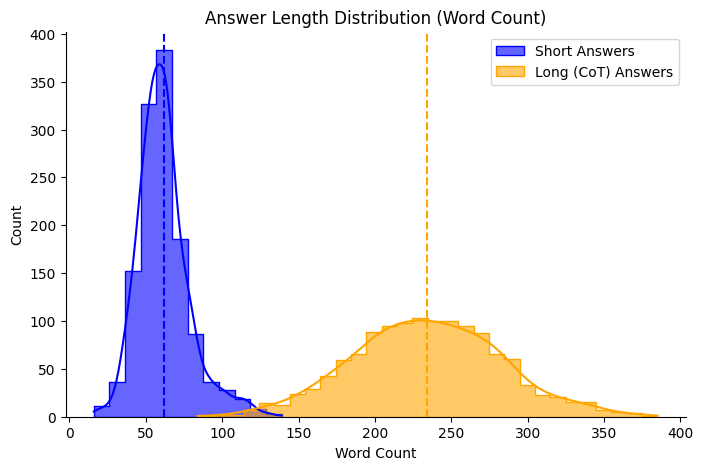

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Answer lengths
df['len_a1'] = df['answer1'].apply(lambda x: len(str(x).split()))
df['len_a2'] = df['answer2'].apply(lambda x: len(str(x).split()))
df['len_a3'] = df['answer3'].apply(lambda x: len(str(x).split()))

# Error control
problematic_lengths = df[(df['len_a3'] < df['len_a1']) | (df['len_a3'] < df['len_a2'])]
print(f"\n Number of rows where Answer 3 (CoT) is shorter than Answer 1/2: {len(problematic_lengths)}")


plt.figure(figsize=(8, 5))
    
# Set a fixed bin width so bars are equal width for both
bin_width = 10
short_answers_len = df['len_a1']+df['len_a2']

sns.histplot(short_answers_len, color='blue', label='Short Answers', kde=True, alpha=0.6, binwidth=bin_width, element='step')
sns.histplot(df['len_a3'], color='orange', label='Long (CoT) Answers', kde=True, alpha=0.6, binwidth=bin_width, element='step')

plt.xticks(np.arange(0, df['len_a3'].max() + 50, 50))

plt.legend()
plt.title('Answer Length Distribution (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Count')

# Mean lines
plt.axvline(short_answers_len.mean(), color='blue', linestyle='--', label='Mean Short Answers')
plt.axvline(df['len_a3'].mean(), color='orange', linestyle='--', label='Mean Long Answers')

sns.despine()

plt.show()

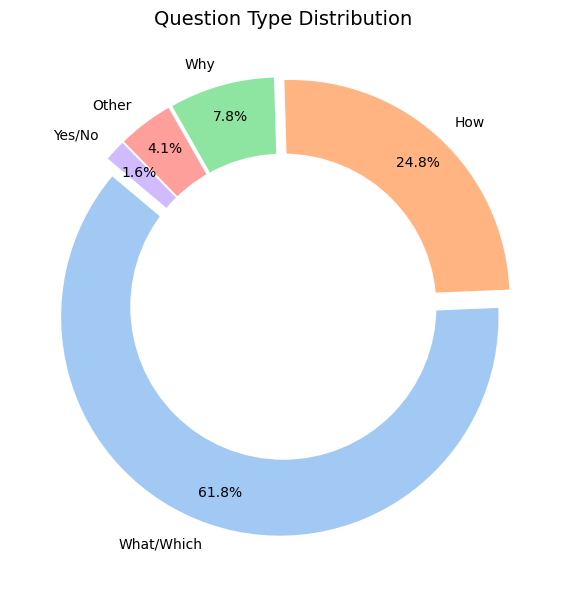

\Distribution
question_type
What/Which    787
How           316
Why            99
Other          52
Yes/No         20
Name: count, dtype: int64


In [117]:
def categorize_question(text):
    text = str(text).lower()
    
    why_keywords = [
        'neden', 'niye', 'niçin'
    ]
    if any(word in text for word in why_keywords):
        return 'Why'

    how_keywords = [
        'nasıl', 'hangi yolla',
    ]
    if any(word in text for word in how_keywords):
        return 'How'
    
    what_keywords = [
        'nedir', ' ne ', 'hangi', 'neler'
    ]
    if any(word in text for word in what_keywords):
        return 'What/Which'

    verification_keywords = [' mı', ' mi', ' mu', ' mü', 'mıdır', 'midir', 'mudur', 'müdür']
    if any(word in text for word in verification_keywords):
        return 'Yes/No'

    return 'Other'

df['question_type'] = df['question'].apply(categorize_question)

# Calculate counts
type_counts = df['question_type'].value_counts()

# Plotting
plt.figure(figsize=(6, 6))

colors = sns.color_palette('pastel')[0:5]

plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, pctdistance=0.85, explode=[0.05]*len(type_counts))

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Question Type Distribution', fontsize=14)
plt.tight_layout()
plt.show()

# Print raw numbers for report
print("\Distribution")
print(type_counts)

C:\Users\Oğuzhan ÇELİK\AppData\Local\Temp\ipykernel_30512\866490066.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_words, palette='viridis')


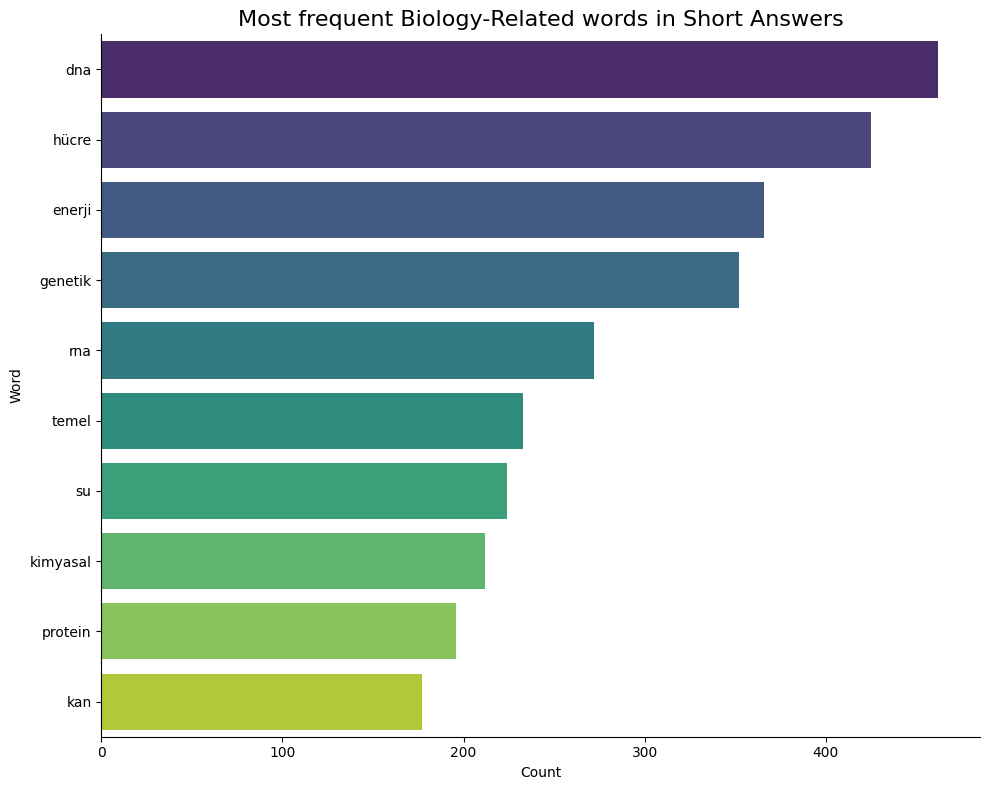

In [ ]:
from collections import Counter
import re

# These words are determined manually after checking all frequent words to only include biology-related terms in top 10.
stop_words = ['ve', 'bir', 'iki', 'bu', 'veya', 'için', 'olarak', 'gibi', 'daha', 'ise', 'genellikle', 'ile', 'da', 'de', 'sağlar', 'olan',
                'her', 'farklı', 'yüksek', 'arasında', 'belirli']

# Convert answers to a list of strings
all_text = " ".join((df['answer1']+df['answer2']).astype(str)).lower()

words = re.findall(r'\w+', all_text)

filtered_words = [w for w in words if w not in stop_words and len(w) > 1]

word_counts = Counter(filtered_words)

most_common = word_counts.most_common(10)

# Visualization
df_words = pd.DataFrame(most_common, columns=['Word', 'Count'])

plt.figure(figsize=(10, 8))
sns.barplot(x='Count', y='Word', data=df_words, palette='viridis')

plt.title(f'Most frequent Biology-Related words in Short Answers', fontsize=16)

sns.despine()
plt.tight_layout()
plt.show()

In [114]:
# While this chart shows a general idea, it is not perfectly correct as it only looks for exact word matches.
# For example, the word "enzim" would be more frequent than "kan" if we considered different forms/suffixes of the words.
enzim_count = word_counts.get('enzim') + word_counts.get('enzimler', 0) + word_counts.get('enzimi', 0) + word_counts.get('enzimleri', 0) + word_counts.get('enzimin', 0) + word_counts.get('enzimlerin', 0)
kan_count = word_counts.get('kan') + word_counts.get('kanlar', 0) + word_counts.get('kanı', 0) + word_counts.get('kanları', 0) + word_counts.get('kanın', 0) + word_counts.get('kanların', 0)
print(f"\nEnzim total count (all forms): {enzim_count}")
print(f"Kan total count (all forms): {kan_count}")


Enzim total count (all forms): 231
Kan total count (all forms): 224


# Question-Answer Modifications

Doubling Question Count

In [ ]:
import json
from google import genai
import math

API_KEY = "########"

def create_response(batch_of_questions):
    client = genai.Client(api_key=API_KEY)

    response = client.models.generate_content(
        model="gemini-2.5-flash",

        contents= f"""Aşağıdaki JSON listesindeki her bir nesne için:

        1.  Mevcut **"question"** ve **"answer1"**, **"answer2"**, **"answer3"** değerlerini koru.
        2.  **"new_question"** adında yeni bir anahtar (key) ekle.
        3.  Bu **"new_question"** anahtarının değeri, mevcut cevaplar (answer1, answer2, answer3) ile aynı anlama gelecek, ancak **ifadesi tamamen farklı** olan bir soru olsun.
        4.  Çıktıyı yalnızca istenen formatta (JSON listesi) döndür.

        Girdi verisi: {batch_of_questions}""",
    )

    return response.text

BATCH_SIZE = 50
with open('data/Questions_answers_dataset.json', 'r', encoding='utf-8') as file:
    questions = json.load(file)

num_batches = math.ceil(len(questions) / BATCH_SIZE)

all_generated_data = []

for i in range(0, num_batches):
    start_index = i * BATCH_SIZE
    end_index = (i + 1) * BATCH_SIZE

    batch = questions[start_index:end_index]

    if not batch:
        break

    print(f"\n--- Grup {i + 1}/{num_batches} (İndeksler: {start_index}-{end_index - 1}) ---")

    response_text = create_response(batch)

    # Save the response
    try:
        # Clean up Markdown code blocks if the API returns them (e.g., ```json ... ```)
        cleaned_text = response_text.replace("```json", "").replace("```", "").strip()
        
        # Convert string response to Python list/dict
        batch_json = json.loads(cleaned_text)

        # Add to the main list
        if isinstance(batch_json, list):
            all_generated_data.extend(batch_json)
        else:
            all_generated_data.append(batch_json)
            
        print(f" > Batch {i + 1} added successfully. Total count: {len(all_generated_data)}")

        with open("data/double_questions_dataset.json", 'w', encoding='utf-8') as outfile:
            json.dump(all_generated_data, outfile, ensure_ascii=False, indent=4)

    except json.JSONDecodeError as e:
        print(f"Error parsing JSON in batch {i + 1}: {e}")
        with open(f'error_batch_{i+1}.txt', 'w', encoding='utf-8') as err_file:
            err_file.write(response_text)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Fix CoT Format

In [ ]:
from google.genai import types

def process_batch(batch_data):
    client = genai.Client(api_key=API_KEY)

    json_string = json.dumps(batch_data, ensure_ascii=False)

    prompt_text = f"""
    Sen, metin düzenleme ve doğal dil işleme konusunda uzmanlaşmış bir yapay zeka asistanısın. Görevin, sana verilecek olan JSON formatındaki soru-cevap çiftlerini analiz etmek ve "cevap" kısımlarını yeniden yazmaktır.

    GİRDİ FORMATI:
    Sana içinde "id", "soru" ve "cevap" alanları bulunan bir JSON listesi verilecek. Şu anki "cevap" alanları "Chain-of-Thought" (CoT) yöntemiyle yazılmış.

    GÖREVİN:
    Bu "cevap" metinlerini alıp, numaralandırmayı, başlıkları ve "Sonuç:" gibi etiketleri kaldırarak akıcı, bütünlüklü ve doğal bir paragrafa dönüştür.

    KURALLAR:
    1. ANLAM BÜTÜNLÜĞÜ: Cevabın teknik bilgisini koru.
    2. FORMAT: Madde işareti veya numara ASLA kullanma. Sadece düz yazı (prose) olsun.
    3. YAPISAL DÖNÜŞÜM: Adım adım düşünme sürecini bağlaçlarla bağlanan cümlelere çevir.
    4. KAPSAM: Listedi HİÇBİR soruyu atlama.
    5. ÇIKTI FORMATI: Sadece JSON listesi döndür. Markdown (```json) kullanma.
    
    İstenen Çıktı Yapısı:
    [
      {{
        "id": (Girdideki ID, integer olarak), 
        "yeni_cevap": "Düzenlenmiş paragraf..."
      }}
    ]

    İŞLENECEK VERİ:
    {json_string}
    """

    try:
        response = client.models.generate_content(
            model="gemini-2.5-flash",
            contents=prompt_text,
            config=types.GenerateContentConfig(
                response_mime_type="application/json",
                temperature=0.2
            )
        )
        return response.text
    except Exception as e:
        print(f"API Hatası: {e}")
        return None

input_filename = 'data/double_questions_dataset.json'
output_filename = 'data/cleaned_double_questions_dataset.json'

with open(input_filename, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)
print(f"{len(raw_data)} rows loaded.")

api_input_list = []
for index, item in enumerate(raw_data):
    api_input_list.append({
        "id": index,
        "soru": item.get("question"),
        "cevap": item.get("answer3") # CoT answer
    })

# Process in Batches
batch_size = 2
processed_answers = {}

for i in range(0, len(api_input_list), batch_size):
    batch = api_input_list[i:i + batch_size]
    print(f"Batch işleniyor: {i} - {min(i + batch_size, len(api_input_list))}")
    
    json_response = process_batch(batch)
    
    if json_response:
        try:
            parsed_data = json.loads(json_response)
            # Save the processed answers
            for item in parsed_data:
                processed_answers[item['id']] = item['yeni_cevap']
        except json.JSONDecodeError:
            print(f"JSON Parse Hatası (Batch {i})")
        
        error_file = f"outputs/raw_output_batch_{i}.txt"
        with open(error_file, "w", encoding="utf-8") as err_f:
            err_f.write(json_response)
    
    time.sleep(1)

# Combine the data
print("Combining the data...")
success_count = 0

for index, item in enumerate(raw_data):
    # Update answer3 with processed answer
    if index in processed_answers:
        item['answer3'] = processed_answers[index]
        success_count += 1

# Save
with open(output_filename, 'w', encoding='utf-8') as f:
    json.dump(raw_data, f, ensure_ascii=False, indent=4)

print(f"İşlem tamamlandı! Toplam {len(raw_data)} sorudan {success_count} tanesi güncellendi.")
print(f"Dosya kaydedildi: {output_filename}")

# Train-Val-Test Sets

Splitting the dataset so each question falls into the same split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# We loaded the dataset as initial_dataset.json to google colab drive. Codes after this are run in colab.
import random

# Load dataset
with open("/content/drive/MyDrive/Dl_ project/Dataset/initial_dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Shuffle questions
random.shuffle(data)

# Split indices
n = len(data)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

train_raw = data[:train_end]
val_raw = data[train_end:val_end]
test_raw = data[val_end:]

print(len(train_raw), len(val_raw), len(test_raw))

In [ ]:
base_path ="/content/drive/MyDrive/Dl_ project/Dataset/"

train_in = base_path + "train_raw.json"
val_in   = base_path + "val_raw.json"
test_in  = base_path + "test_raw.json",

In [ ]:
# Save train_raw
with open(train_in, "w", encoding="utf-8") as f:
    json.dump(train_raw, f, ensure_ascii=False, indent=2)

# Save val_raw
with open(val_in, "w", encoding="utf-8") as f:
    json.dump(val_raw, f, ensure_ascii=False, indent=2)

# Save test_raw
with open(test_in, "w", encoding="utf-8") as f:
    json.dump(test_raw, f, ensure_ascii=False, indent=2)

print("Saved train_raw.json, val_raw.json, test_raw.json")



Remove Answer 3 (COT) for No_COT Models

In [ ]:

def remove_answer3(input_path, output_path):
    # Read the JSON file
    with open(input_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Remove answer3 if exists
    for item in data:
        item.pop("answer3", None)


    # Save the cleaned file
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

    print("answer3 removed successfully!")

no_cot_path = base_path + "Dataset_old_cot/dataset_no_cot/"
remove_answer3(test_in, no_cot_path + "test_raw_no_cot.json")
remove_answer3(train_in, no_cot_path + "train_raw_no_cot.json")
remove_answer3(val_in, no_cot_path + "val_raw_no_cot.json")

Convert splits to message format

In [ ]:


def convert_dataset_to_messages(input_file, output_file):
    """
    Converts each item in the dataset into multiple message pairs:
    (q, answer1), (q, answer2), (q, answer3)
    """

    # Load dataset
    try:
        with open(input_file, "r", encoding="utf-8") as f:
            data = json.load(f)
        print(f"Loaded: {len(data)} items from {input_file}")
    except FileNotFoundError:
        print(f"Error: Could not find {input_file}. Please check the file path.")
        return

    rewritten = []

    # Conversion loop
    for item in data:
        q = item.get("question", "").strip()
        if not q:
            continue

        a1 = item.get("answer1", "").strip()
        a2 = item.get("answer2", "").strip()
        a3 = item.get("answer3", "").strip()

        # Short answer 1
        if a1:
            rewritten.append({
                "messages": [
                    {"role": "user", "content": q},
                    {"role": "assistant", "content": a1}
                ]
            })

        # Short answer 2
        if a2:
            rewritten.append({
                "messages": [
                    {"role": "user", "content": q},
                    {"role": "assistant", "content": a2}
                ]
            })

        # COT answer 3

        if a3:
            rewritten.append({
                "messages": [
                    {"role": "user", "content": q},
                    {"role": "assistant", "content": a3}
                ]
            })

    print(f"Final dataset rows: {len(rewritten)}")

    # Save output
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(rewritten, f, ensure_ascii=False, indent=2)

    print(f"Saved to: {output_file}")

train_out = base_path + "Dataset_after_updating_cot/new_cot_formatted_data/train_messages_new_cot.json"
val_out   = base_path + "Dataset_after_updating_cot/new_cot_formatted_data/val_messages_new_cot.json"
test_out  = base_path + "Dataset_after_updating_cot/new_cot_formatted_data/test_messages_new_cot.json"

convert_dataset_to_messages(train_in, train_out)
convert_dataset_to_messages(val_in, val_out)
convert_dataset_to_messages(test_in, test_out)

Add System prompt to the dataset for system_prompt models

In [ ]:
# SYSTEM PROMPTS
def add_prompt_to_message(input_file, output_file):
    """
    Adds system prompts to each message pair in the dataset.
    """
    # Prompt for Short/Standard Answers (Answer 1 & 2)
    system_short = (
        "Sen bir biyoloji asistanısın. Soruyu açık, anlaşılır ve orta uzunlukta bir açıklamayla cevapla. "
        "Gereksiz ayrıntılara girme, mantık adımlarını veya çözüm sürecini açıkça göstermeden "
        "sonuç odaklı ve öğretici bir yanıt üret. "
        "Yanıtın doğal, akıcı ve bilgilendirici olmasına dikkat et."
    )

    # Prompt for Chain of Thought Answers (Answer 3)
    system_cot = (
        "Sen uzman bir biyoloji öğretmenisin. Soruyu adım adım düşünerek cevapla. "
        "Önce problemi analiz et, ardından mantıklı bir akış içinde gerekçeleri sırala ve "
        "her adımda neden-sonuç ilişkisini açıkla. "
        "En sonunda ise net ve güçlü bir sonuç paragrafı yaz."
    )

    # Load dataset
    try:
        with open(input_file, "r", encoding="utf-8") as f:
            data = json.load(f)
        print(f"Loaded: {len(data)} items from {input_file}")
    except FileNotFoundError:
        print(f"Error: Could not find {input_file}. Please check the file path.")
        data = []

    rewritten = []

    for item in data:
        q = item.get("question", "").strip()

        # Skip if question is missing
        if not q:
            continue

        # Extract answers safely
        a1 = item.get("answer1", "").strip()
        a2 = item.get("answer2", "").strip()
        a3 = item.get("answer3", "").strip()

        # short answer 1
        if a1:
            rewritten.append({
                "messages": [
                    {"role": "system", "content": system_short},
                    {"role": "user", "content": q},
                    {"role": "assistant", "content": a1}
                ]
            })

        # short answer 2
        if a2:
            rewritten.append({
                "messages": [
                    {"role": "system", "content": system_short},
                    {"role": "user", "content": q},
                    {"role": "assistant", "content": a2}
                ]
            })

        # COT answer 3
        if a3:
            rewritten.append({
                "messages": [
                    {"role": "system", "content": system_cot},
                    {"role": "user", "content": q},
                    {"role": "assistant", "content": a3}
                ]
            })

    print(f"Final dataset rows: {len(rewritten)}")

    # Save output
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(rewritten, f, ensure_ascii=False, indent=2)

    print(f"Saved to: {output_file}")

train_out = base_path + "dataset_prompt/train_messages_prompt.json"
val_out   = base_path + "dataset_prompt/val_messages_prompt.json"
test_out  = base_path + "dataset_prompt/test_messages_prompt.json"

add_prompt_to_message(train_in, train_out)
add_prompt_to_message(val_in, val_out)
add_prompt_to_message(test_in, test_out)